In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/ModerateDemented/20.jpg
/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/ModerateDemented/6.jpg
/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/ModerateDemented/14 (2).jpg
/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/ModerateDemented/20 (2).jpg
/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/ModerateDemented/5.jpg
/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/ModerateDemented/8.jpg
/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/ModerateDemented/18 (2).jpg
/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/ModerateDemented/30.jpg
/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/ModerateDemented/4 (2).jpg
/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_

In [26]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc,classification_report,matthews_corrcoef
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [27]:
# Display versions for reproducibility
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [28]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
# Define class mapping
label_mapping = {
    'MildDemented': 'Mild Dementia',
    'ModerateDemented': 'Moderate Dementia',
    'NonDemented': 'Non Demented',
    'VeryMildDemented': 'Very Mild Dementia'
}

# Create a list to store image paths and labels
image_data = []

In [30]:

DATA_DIR ='/kaggle/input/alzheimer-mri-4-classes-dataset/Alzheimer_MRI_4_classes_dataset/'


filepaths = []
labels = []


for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:

        filepath = os.path.join(dirname, filename)

        label = os.path.basename(dirname)
        
        filepaths.append(filepath)
        labels.append(label)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})


print(f"Total images found: {len(df)}")
print("\nFirst 5 rows of the DataFrame:")
print(df.head())
print("\nClass distribution:")
print(df['label'].value_counts())

Total images found: 6400

First 5 rows of the DataFrame:
                                            filepath             label
0  /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
1  /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
2  /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
3  /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented
4  /kaggle/input/alzheimer-mri-4-classes-dataset/...  ModerateDemented

Class distribution:
label
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64


In [31]:
img=Image.open(df.iloc[10]['filepath'])
img.size #(w,h)

(176, 208)

In [32]:
np_img=np.array(img)
np_img.shape #(h,w,c)

(208, 176)

In [33]:
print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Total samples: {len(df)}")

DATASET OVERVIEW
Total samples: 6400



CLASS DISTRIBUTION
Class distribution:
Class NonDemented (Non Demented): 3200 images (50.00%)
Class VeryMildDemented (Very Mild Dementia): 2240 images (35.00%)
Class MildDemented (Mild Dementia): 896 images (14.00%)
Class ModerateDemented (Moderate Dementia): 64 images (1.00%)


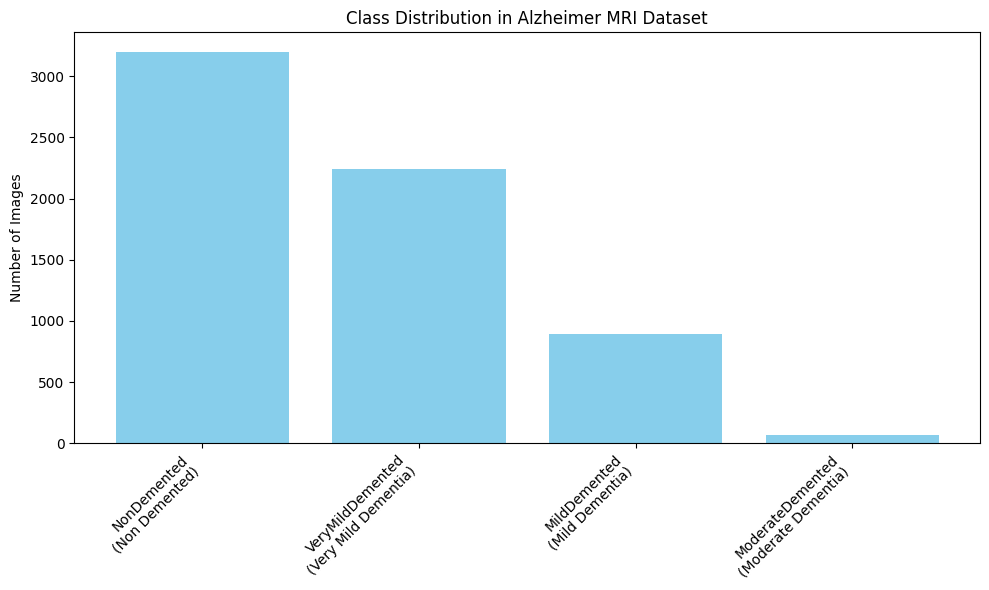

In [34]:
print("\n" + "=" * 50)
print("CLASS DISTRIBUTION")
print("=" * 50)

class_counts = df['label'].value_counts()

print("Class distribution:")
for label, count in class_counts.items():
    print(f"Class {label} ({label_mapping.get(label, 'Unknown')}): {count} images ({count/len(df)*100:.2f}%)")

# Plot class distribution
plt.figure(figsize=(10, 6))
labels = [f"{label}\n({label_mapping.get(label, 'Unknown')})" for label in class_counts.index]
plt.bar(labels, class_counts.values, color='skyblue')
plt.title('Class Distribution in Alzheimer MRI Dataset')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()
plt.close()

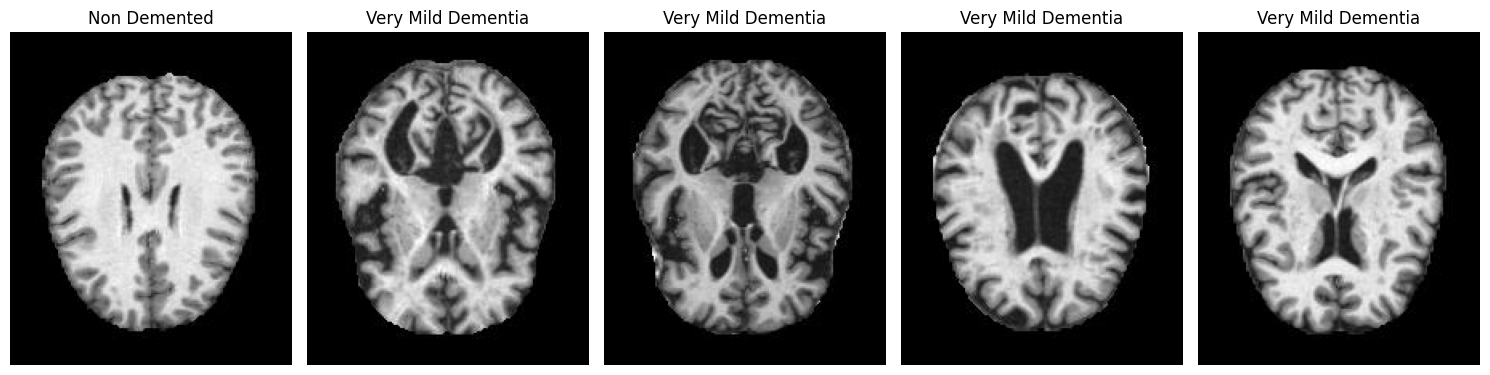

In [35]:
# Define image dimensions
#IMG_SIZE = 224  # According to requirements'


def preprocess_image(img_path):
    """
    Preprocess image: resize and normalize using max-min method
    """
    img = Image.open(img_path)
    #img = img.resize((IMG_SIZE, IMG_SIZE))  # Resize to 224 x 224
    img_array = np.array(img)
    
    # Convert grayscale to RGB if needed
    if len(img_array.shape) == 2:
        img_array = np.stack((img_array,) * 3, axis=-1)
    elif img_array.shape[2] == 1:
        img_array = np.concatenate([img_array, img_array, img_array], axis=-1)
    
    # Ensure we only have 3 channels (RGB)
    img_array = img_array[:, :, :3]
    
    # Max-min normalization
    img_array = img_array / 255.0
    
    return img_array

sample_size = min(5, len(df))
plt.figure(figsize=(15, 5))
for i in range(sample_size):
    idx = np.random.randint(0, len(df))
    img_path = df.iloc[idx]['filepath']
    label = df.iloc[idx]['label']
    
    # Preprocess image
    img_array = preprocess_image(img_path)
    
    # Display image
    plt.subplot(1, sample_size, i+1)
    plt.imshow(img_array)
    plt.title(f"{label_mapping.get(label, 'Unknown')}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('preprocessed_samples.png')
plt.show()
plt.close()

In [36]:
label_to_idx = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Add encoded labels to dataframe
df['label_encoded'] = df['label'].map(label_to_idx)

print("Label encodings:")
for label, idx in label_to_idx.items():
    print(f"{label} ({label_mapping.get(label, 'Unknown')}) -> {idx}")

Label encodings:
MildDemented (Mild Dementia) -> 0
ModerateDemented (Moderate Dementia) -> 1
NonDemented (Non Demented) -> 2
VeryMildDemented (Very Mild Dementia) -> 3


In [37]:
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Check class distribution in splits
print("\nClass distribution in training set:")
train_class_counts = train_df['label'].value_counts()
for label, count in train_class_counts.items():
    print(f"{label}: {count} images ({count/len(train_df)*100:.2f}%)")

Training set: 3840 images
Validation set: 1280 images
Test set: 1280 images

Class distribution in training set:
NonDemented: 1920 images (50.00%)
VeryMildDemented: 1344 images (35.00%)
MildDemented: 538 images (14.01%)
ModerateDemented: 38 images (0.99%)


In [38]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input

IMG_SIZE = 224 

def resize_pad_and_preprocess(image):
    """
    This function will be called by ImageDataGenerator for each image.
    It first resizes with padding and then applies model-specific preprocessing.
    """
    # Resize and pad the image to maintain the aspect ratio
    image = tf.image.resize_with_pad(
        image,
        target_height=IMG_SIZE,
        target_width=IMG_SIZE
    )
    # Apply the preprocessing required by the ResNet50 model
    image = preprocess_input(image)
    return image

In [39]:
train_datagen = ImageDataGenerator(
    rotation_range=10,               # mild rotation
    width_shift_range=0.05,          # small translation
    height_shift_range=0.05,
    zoom_range=0.1,                  # small zoom in/out
    brightness_range=[0.9, 1.1],     # mild brightness adjustment
    fill_mode='nearest',
    preprocessing_function=resize_pad_and_preprocess
)


In [40]:
val_datagen = ImageDataGenerator(
    preprocessing_function=resize_pad_and_preprocess # Use the same function here
)
test_datagen = ImageDataGenerator(
    preprocessing_function=resize_pad_and_preprocess
)

Found 3840 validated image filenames belonging to 4 classes.
Found 1280 validated image filenames belonging to 4 classes.
Found 1280 validated image filenames belonging to 4 classes.


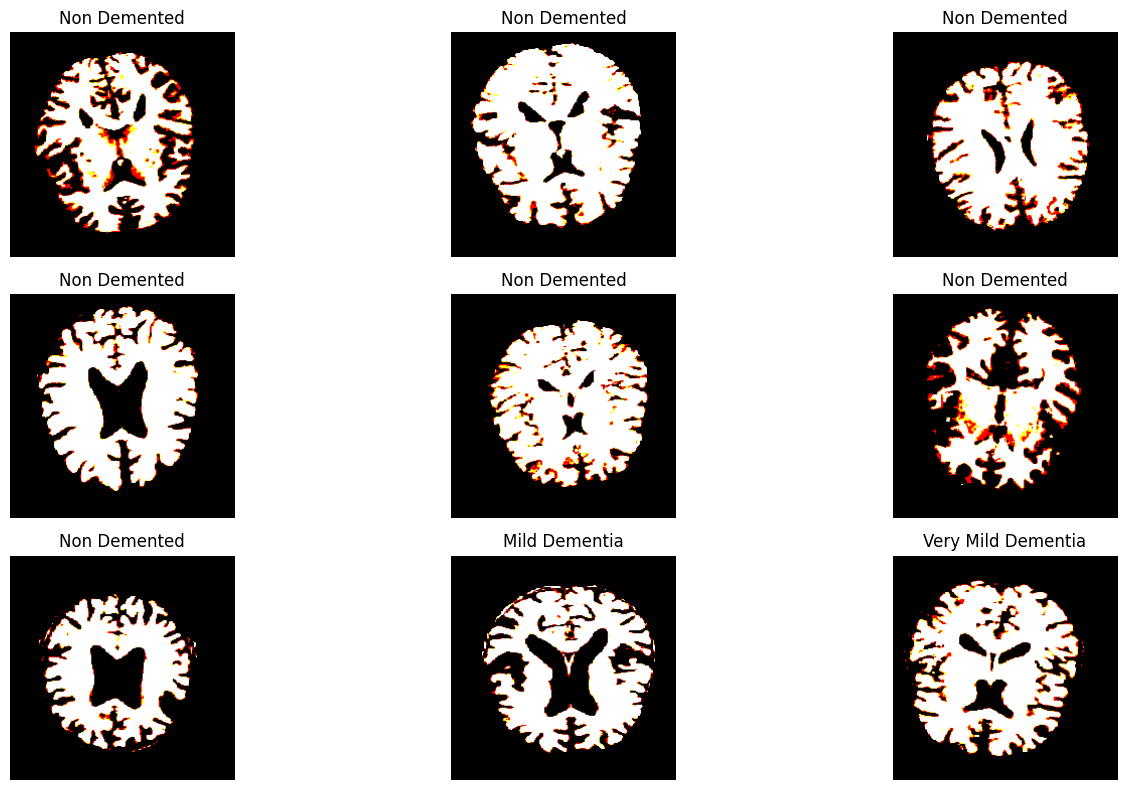

In [41]:
IMG_SIZE = 224 # Make sure this is defined

def create_generators(batch_size=32):
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepath',
        y_col='label',
        # Ensure this target_size matches your preprocessing function
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        classes=sorted(label_to_idx.keys())
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filepath',
        y_col='label',
        # Also update it here
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        classes=sorted(label_to_idx.keys())
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepath',
        y_col='label',
        # And here
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        classes=sorted(label_to_idx.keys())
    )

    return train_generator, val_generator, test_generator

# Re-create your generators with the corrected function
train_generator, val_generator, test_generator = create_generators(batch_size=32)

# Display a batch of augmented images to verify
def display_augmented_images():
    # Get a batch of augmented images
    x_batch, y_batch = next(train_generator)
    
    plt.figure(figsize=(15, 8))
    for i in range(min(9, len(x_batch))):
        plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])
        label_idx = np.argmax(y_batch[i])
        label = idx_to_label[label_idx]
        plt.title(f"{label_mapping.get(label, 'Unknown')}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('augmented_samples.png')
    plt.show()
    plt.close()

display_augmented_images()

In [42]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_resnet50_model(input_shape=(224, 224, 3), num_classes=len(label_to_idx)):
    """
    Build ResNet50 model with fine-tuning, using custom input shape.
    """
    # Load pre-trained ResNet50 without top layers
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))


    # Selectively unfreeze layers for fine-tuning
    trainable = False
    for layer in base_model.layers:
        if 'conv5' in layer.name:  # Unfreeze last conv block
            trainable = True
        layer.trainable = trainable

    print(f"Building ResNet50 model with {num_classes} output classes and input shape {input_shape}")

    # Build the model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x=BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    

    model = Model(inputs=inputs, outputs=outputs)
    return model

resnet50_model = build_resnet50_model()
resnet50_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Building ResNet50 model with 4 output classes and input shape (224, 224, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,121,476 (92.02 MB)

 Trainable params: 15,505,668 (59.15 MB)

 Non-trainable params: 8,615,808 (32.87 MB)

In [43]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights from the training generator
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.7843866171003717, 1: 25.263157894736842, 2: 0.5, 3: 0.7142857142857143}


In [44]:
epochs=30
# Compile the model with Adam optimizer
resnet50_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks for model training
model2_callbacks = [
    ModelCheckpoint('resnet50_model_best.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6, monitor='val_loss')
]

# Train the model
print("Training the Resnet50 model...")

history_resnet50 = resnet50_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=model2_callbacks,
    class_weight=class_weights_dict  
)

Training the Resnet50 model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1757594572.528504     107 service.cc:148] XLA service 0x7a14d4002100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757594572.531254     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757594572.531274     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757594574.906896     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/120 ━━━━━━━━━━━━━━━━━━━━ 1:01:58 31s/step - accuracy: 0.1875 - loss: 2.2160

I0000 00:00:1757594584.737885     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.3025 - loss: 1.7941 - val_accuracy: 0.4313 - val_loss: 1.3889 - learning_rate: 1.0000e-04
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 106s 884ms/step - accuracy: 0.5565 - loss: 0.8250 - val_accuracy: 0.6328 - val_loss: 0.8580 - learning_rate: 1.0000e-04
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 105s 877ms/step - accuracy: 0.6374 - loss: 0.7306 - val_accuracy: 0.6500 - val_loss: 0.8385 - learning_rate: 1.0000e-04
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 105s 878ms/step - accuracy: 0.7159 - loss: 0.5256 - val_accuracy: 0.7406 - val_loss: 0.6561 - learning_rate: 1.0000e-04
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 106s 883ms/step - accuracy: 0.7761 - loss: 0.4181 - val_accuracy: 0.7484 - val_loss: 0.6254 - learning_rate: 1.0000e-04
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 106s 884ms/step - accuracy: 0.7915 - loss: 0.4053 - val_accuracy: 0.7977 - val_loss: 0.5216 - learning_rate: 1.0000e-04
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 105s 878ms/ste

In [45]:
resnet50_model.save('resnet50_model_final_50epochs_224.keras')

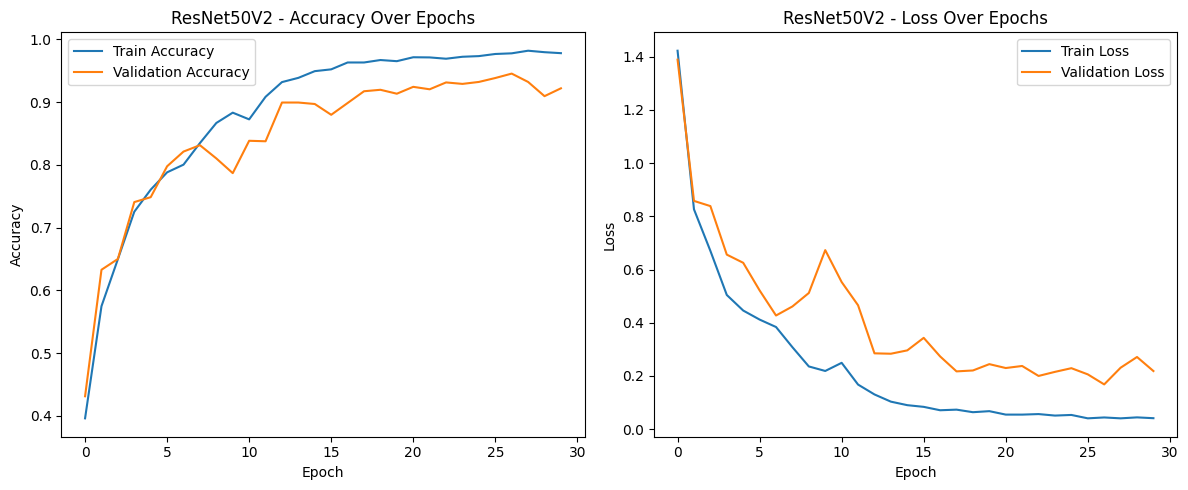

In [46]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()
    plt.close()

# Plot training history for both models
#plot_training_history(history_resnet152, 'ResNet152V2')
plot_training_history(history_resnet50, 'ResNet50V2')


Evaluating ResNet50V2 model...
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 606ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 396ms/step - accuracy: 0.9477 - loss: 0.1279
ResNet50V2 - Test Accuracy: 0.9531, Test Loss: 0.1333
ResNet50V2 - Top-5 Accuracy: Not applicable (only 4 classes)


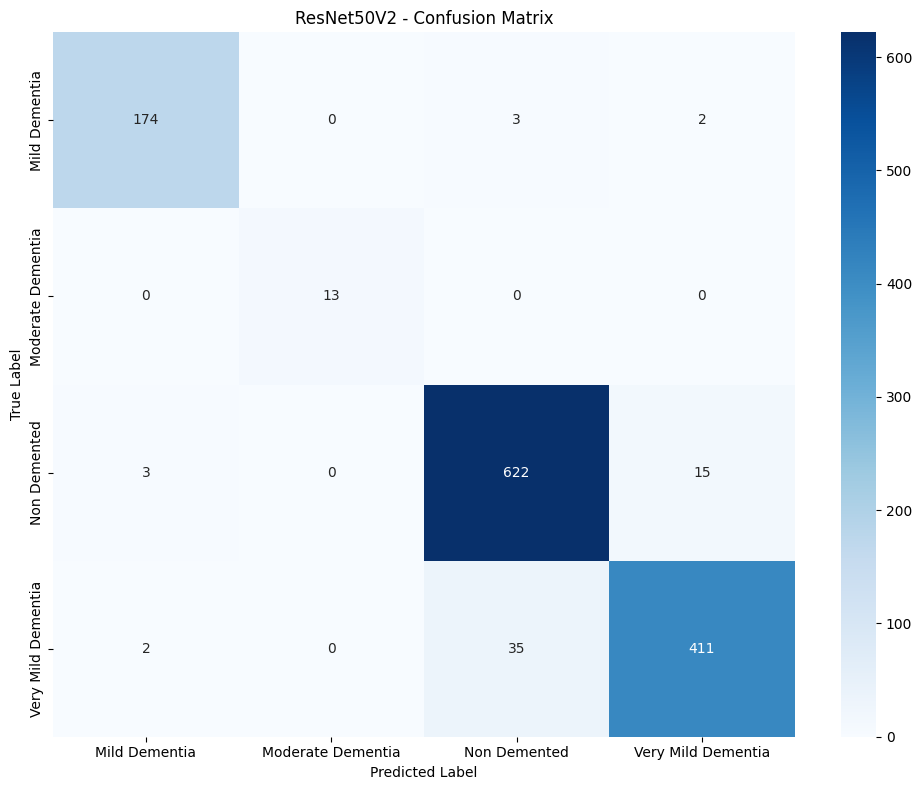


ResNet50V2 - Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       0.97      0.97      0.97       179
 Moderate Dementia       1.00      1.00      1.00        13
      Non Demented       0.94      0.97      0.96       640
Very Mild Dementia       0.96      0.92      0.94       448

          accuracy                           0.95      1280
         macro avg       0.97      0.97      0.97      1280
      weighted avg       0.95      0.95      0.95      1280



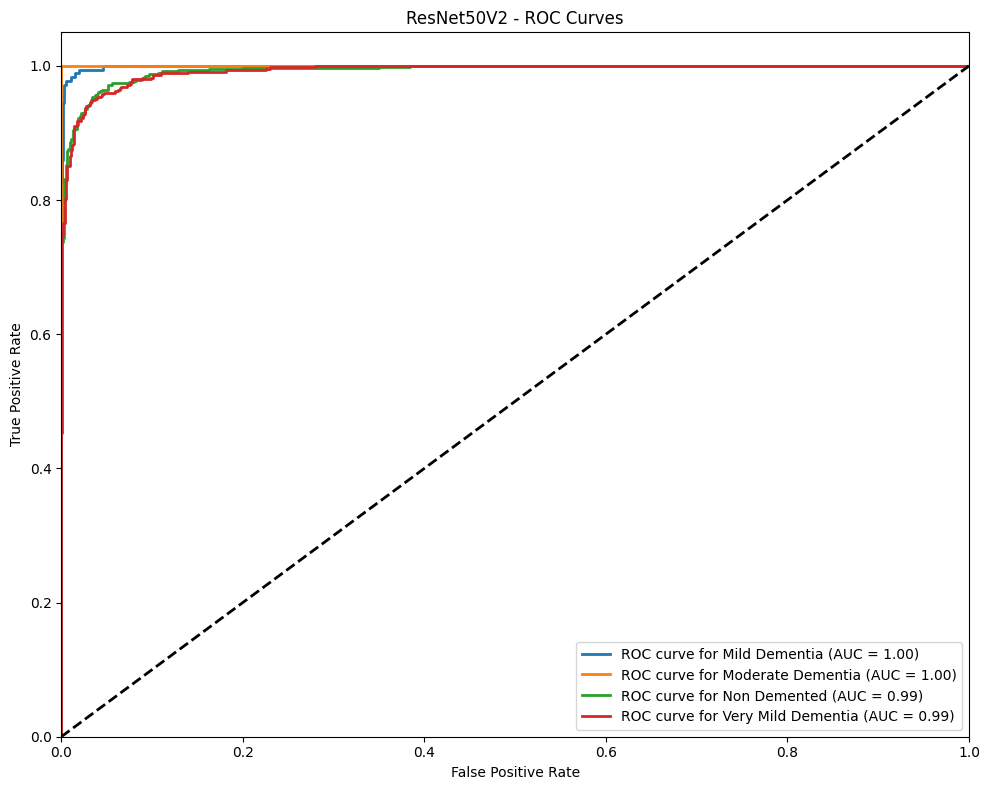

ResNet50V2 - Average Matthews Correlation Coefficient: 0.9468

ResNet50V2 - PERFORMANCE METRICS SUMMARY
Accuracy (ACC): 0.9531
Top-1 Accuracy: 0.9531
Precision: 0.9687
Recall: 0.9653
F1 Score: 0.9668
Average AUC: 0.9962
Matthews Correlation Coefficient (MCC): 0.9468
Loss: 0.1333


In [48]:

def evaluate_model(model, test_generator, model_name):
    """
    Comprehensive evaluation of the model using multiple metrics:
    - Accuracy
    - Top-1 and Top-5 Accuracy
    - Precision, Recall, F1 Score
    - ROC Curve and AUC
    - Matthews Correlation Coefficient (MCC)
    - Confusion Matrix
    """
    # Reset the generator
    test_generator.reset()
    
    # Get true labels and predictions
    y_true = np.array(test_generator.classes)
    y_pred_probs = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
    # Calculate basic metrics
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'{model_name} - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')
    
    # 1. Top-1 Accuracy (already calculated as test_acc)
    top1_acc = test_acc
    
    # 2. Top-5 Accuracy (if applicable)
    num_classes = y_pred_probs.shape[1]
    if num_classes >= 5:
        # Get the top 5 predictions for each sample
        top5_preds = np.argsort(y_pred_probs, axis=1)[:, -5:]
        # Check if true class is in top 5 for each sample
        top5_acc = np.mean([y_true[i] in top5_preds[i] for i in range(len(y_true))])
        print(f'{model_name} - Top-5 Accuracy: {top5_acc:.4f}')
    else:
        top5_acc = None
        print(f'{model_name} - Top-5 Accuracy: Not applicable (only {num_classes} classes)')
    
    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[label_mapping.get(idx_to_label[i], 'Unknown') for i in range(len(idx_to_label))],
                yticklabels=[label_mapping.get(idx_to_label[i], 'Unknown') for i in range(len(idx_to_label))])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()
    plt.close()
    
    # 4. Classification Report (Precision, Recall, F1 Score)
    target_names = [label_mapping.get(idx_to_label[i], 'Unknown') for i in range(len(idx_to_label))]
    report = classification_report(y_true, y_pred_classes, target_names=target_names, output_dict=True)
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=target_names))
    
    # Extract metrics from report
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']
    
    # 5. ROC Curve and AUC (for each class in a one-vs-rest manner)
    plt.figure(figsize=(10, 8))
    
    # For each class
    auc_scores = []
    for i in range(num_classes):
        # Convert to binary classification problem
        y_true_binary = (y_true == i).astype(int)
        y_score = y_pred_probs[:, i]
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        
        # Plot ROC curve for this class
        plt.plot(fpr, tpr, lw=2, 
                 label=f'ROC curve for {label_mapping.get(idx_to_label[i], "Unknown")} (AUC = {roc_auc:.2f})')
    
    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curves')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f'{model_name}_roc_curves.png')
    plt.show()
    plt.close()
    
    # 6. Matthews Correlation Coefficient (MCC)
    # For multi-class, we'll use the average MCC across all classes (one-vs-rest)
    mcc_scores = []
    for i in range(num_classes):
        # Convert to binary
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred_classes == i).astype(int)
        
        # Calculate MCC
        class_mcc = matthews_corrcoef(y_true_binary, y_pred_binary)
        mcc_scores.append(class_mcc)
    
    avg_mcc = np.mean(mcc_scores)
    print(f'{model_name} - Average Matthews Correlation Coefficient: {avg_mcc:.4f}')
    
    # Compile all metrics into a dictionary
    metrics = {
        'model_name': model_name,
        'accuracy': test_acc,
        'top1_accuracy': top1_acc,
        'top5_accuracy': top5_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_scores': auc_scores,
        'avg_auc': np.mean(auc_scores),
        'mcc_scores': mcc_scores,
        'avg_mcc': avg_mcc,
        'loss': test_loss,
        'confusion_matrix': cm
    }
    
    # Create a table to display the metrics
    print("\n" + "=" * 50)
    print(f"{model_name} - PERFORMANCE METRICS SUMMARY")
    print("=" * 50)
    print(f"Accuracy (ACC): {test_acc:.4f}")
    print(f"Top-1 Accuracy: {top1_acc:.4f}")
    if top5_acc is not None:
        print(f"Top-5 Accuracy: {top5_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average AUC: {np.mean(auc_scores):.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {avg_mcc:.4f}")
    print(f"Loss: {test_loss:.4f}")
    
    return metrics
    
# Evaluate both models
#print("\nEvaluating ResNet152V2 model...")
#resnet152_metrics = evaluate_model(resnet152_model, test_generator, 'ResNet152V2')

print("\nEvaluating ResNet50V2 model...")
resnet50_metrics = evaluate_model(resnet50_model, test_generator, 'ResNet50V2')

In [51]:
from tensorflow.keras.models import load_model

# Load pretrained model
model = load_model("/kaggle/working/resnet50_model_final_50epochs_224.keras")



Evaluating ResNet50 model...
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 402ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 397ms/step - accuracy: 0.9477 - loss: 0.1279
ResNet50 - Test Accuracy: 0.9531, Test Loss: 0.1333
ResNet50 - Top-5 Accuracy: Not applicable (only 4 classes)


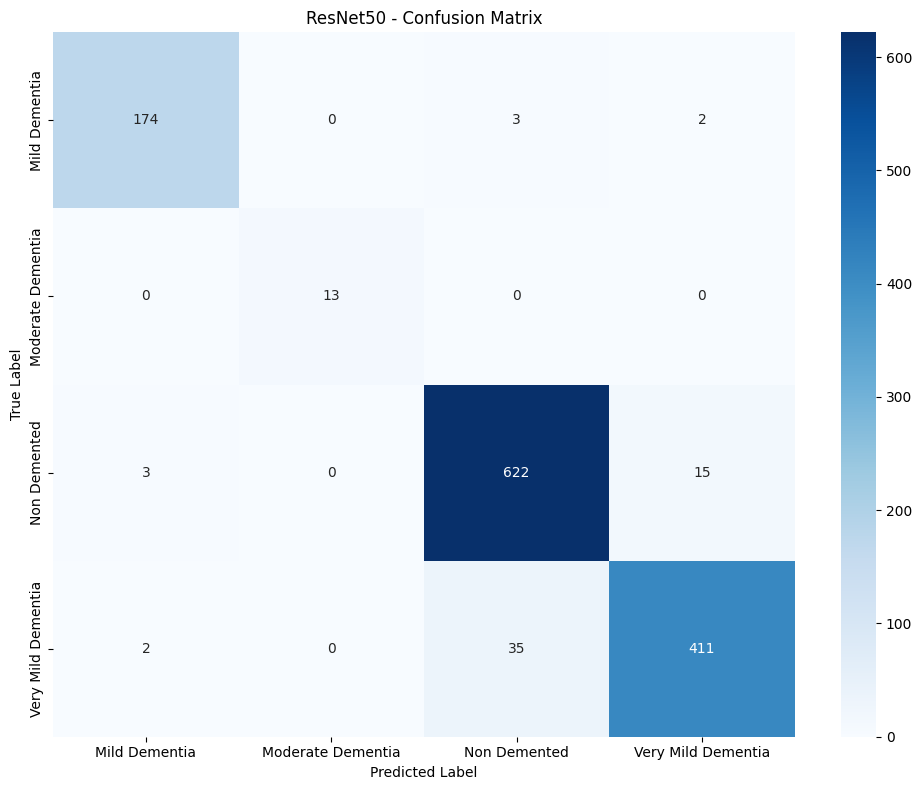


ResNet50 - Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       0.97      0.97      0.97       179
 Moderate Dementia       1.00      1.00      1.00        13
      Non Demented       0.94      0.97      0.96       640
Very Mild Dementia       0.96      0.92      0.94       448

          accuracy                           0.95      1280
         macro avg       0.97      0.97      0.97      1280
      weighted avg       0.95      0.95      0.95      1280



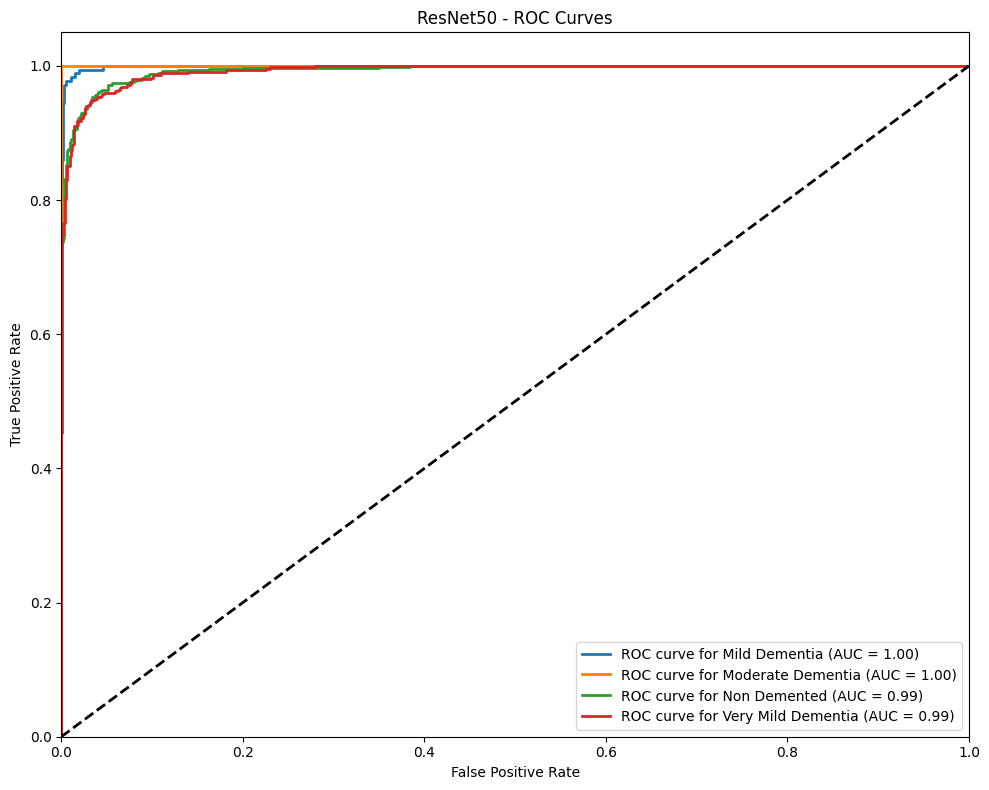

ResNet50 - Average Matthews Correlation Coefficient: 0.9468

ResNet50 - PERFORMANCE METRICS SUMMARY
Accuracy (ACC): 0.9531
Top-1 Accuracy: 0.9531
Precision: 0.9687
Recall: 0.9653
F1 Score: 0.9668
Average AUC: 0.9962
Matthews Correlation Coefficient (MCC): 0.9468
Loss: 0.1333


In [53]:
print("\nEvaluating ResNet50 model...")
resnet50_metrics = evaluate_model(model, test_generator, 'ResNet50')

In [ ]:
# Create a comparison table for all metrics
comparison_metrics = [
    'accuracy', 'precision', 'recall', 'f1_score', 
    'avg_auc', 'avg_mcc', 'loss'
]

# Plot model comparison for all metrics
plt.figure(figsize=(14, 10))
    
# Prepare data for bar chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'MCC']
# resnet152_values = [
#     resnet152_metrics['accuracy'], 
#     resnet152_metrics['precision'], 
#     resnet152_metrics['recall'], 
#     resnet152_metrics['f1_score'], 
#     resnet152_metrics['avg_auc'], 
#     resnet152_metrics['avg_mcc']
# ]
resnet50_values = [
    resnet50_metrics['accuracy'], 
    resnet50_metrics['precision'], 
    resnet50_metrics['recall'], 
    resnet50_metrics['f1_score'], 
    resnet50_metrics['avg_auc'], 
    resnet50_metrics['avg_mcc']
]

# Create grouped bar chart
x = np.arange(len(metrics_names))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 8))
# rects1 = ax.bar(x - width/2, resnet152_values, width, label='ResNet152V2', color='skyblue')
rects2 = ax.bar(x + width/2, resnet50_values, width, label='ResNet50V2', color='lightgreen')

# Add labels and formatting
ax.set_title('Model Comparison - Performance Metrics', fontsize=16)
ax.set_ylabel('Score', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, fontsize=12)
ax.legend(fontsize=12)
ax.set_ylim(0, 1)